# Plot Connectomes

In [11]:
import nilearn.plotting as nip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as  cm

## Load the Power 2011 classification

All of the connectomes in this analysis were extacted from the Power 2011 classification. We will start by first loading the corresponding data table.

In [12]:
power2011 = pd.read_csv("../rsfmri/bin/power_2011.csv")
power2011 = power2011.iloc[:,0:7]
power2011

ROI   X   Y   Z  Network  Color       NetworkName
0      1 -25 -98 -12       -1  White         Uncertain
1      2  27 -97 -13       -1  White         Uncertain
2      3  24  32 -18       -1  White         Uncertain
3      4 -56 -45 -24       -1  White         Uncertain
4      5   8  41 -24       -1  White         Uncertain
..   ...  ..  ..  ..      ...    ...               ...
259  260 -27 -71  37       12  Green  Dorsal attention
260  261 -32  -1  54       12  Green  Dorsal attention
261  262 -42 -60  -9       12  Green  Dorsal attention
262  263 -17 -59  64       12  Green  Dorsal attention
263  264  29  -5  54       12  Green  Dorsal attention

[264 rows x 7 columns]

### Visualize the connectome matrix

We can visualize the connectome matrix for the 62 participants.

In [13]:
R = np.zeros((264, 264, 61))
PR = np.zeros((264, 264, 61))

index = 0
for ii in range(1, 63):
    subj = "sub-%03d" % (ii,)
    if ii != 8:
        R[:,:,index]=np.loadtxt("../rsfmri/%s/R_py.txt" % (subj,))
        PR[:,:,index]=np.loadtxt("../rsfmri/%s/PR_py.txt" % (subj,))
        index += 1


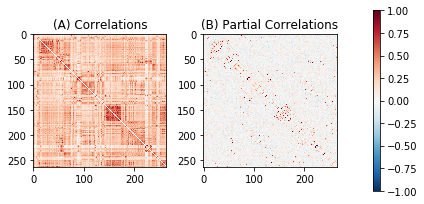

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(6, 3), gridspec_kw={'width_ratios': [20, 20, 1]})
mR = np.mean(R, 2)
mPR = np.mean(PR, 2)

for ii in range(264):
    mR[ii,ii] = 0
    mPR[ii,ii] = 0

im = axs[0].imshow(mR, vmin=-1, vmax=1, cmap="RdBu_r")
axs[0].set_title("(A) Correlations")
fig.colorbar(im, cax=axs[2])
axs[1].imshow(mPR, vmin=-0.25, vmax=0.25, cmap="RdBu_r")
axs[1].set_title("(B) Partial Correlations")
#axs[2].set_visible(False)
plt.tight_layout()
plt.savefig("connectomes.png")

## MLAT-5

We will start with the connectome identified by the 

In [15]:
mlat5 = pd.read_csv("mlat5.csv")
mlat5

index network                                      network_names  \
0   35245     6-6                Memory retrieval?-Memory retrieval?   
1   46638     8-8  Fronto-parietal Task Control-Fronto-parietal T...   
2   49806     8-8  Fronto-parietal Task Control-Fronto-parietal T...   
3   50612     8-8  Fronto-parietal Task Control-Fronto-parietal T...   
4   50865     8-8  Fronto-parietal Task Control-Fronto-parietal T...   
5   51920     8-8  Fronto-parietal Task Control-Fronto-parietal T...   
6   52185     8-8  Fronto-parietal Task Control-Fronto-parietal T...   
7   52462     8-8  Fronto-parietal Task Control-Fronto-parietal T...   
8   52463     8-8  Fronto-parietal Task Control-Fronto-parietal T...   
9   52980     8-8  Fronto-parietal Task Control-Fronto-parietal T...   
10  53243     8-8  Fronto-parietal Task Control-Fronto-parietal T...   
11  53265     8-8  Fronto-parietal Task Control-Fronto-parietal T...   

   connection  censor       Beta  
0     133-134    True   0.849582  
1     174-177    True  -0.108323  
2     174-189    True   7.550569  
3     188-192    True  -1.276513  
4     177-193    True   1.881206  
5     176-197    True  -1.851635  
6     177-198    True  10.512412  
7     190-199    True  -2.068538  
8     191-199    True   0.591173  
9     180-201    True  -0.817286  
10    179-202    True   0.356191  
11    201-202    True  -4.128637

From this data file, we first need to extract the different ROI IDs, which are numbers 1-256 in the Powell 2011 data.

In [16]:
ROIs = []
for c in mlat5['connection']:
    roi1, roi2 = c.split("-")
    
    if int(roi1) not in ROIs:
        ROIs.append(int(roi1))
    if int(roi2) not in ROIs:
        ROIs.append(int(roi2))
ROIs.sort()
ROIs

[133,
 134,
 174,
 176,
 177,
 179,
 180,
 188,
 189,
 190,
 191,
 192,
 193,
 197,
 198,
 199,
 201,
 202]

We then extract the subset of Power 2011 regions that are contained in this connectome, and count the number of ROIs. The number of ROIs, `N`, will be used to create an $N \times N$ matrix.

In [17]:
sub = power2011[power2011['ROI'].isin( ROIs)]
N = len(sub['ROI'])

### Create the Connectome Matrix and Node Coordintes

First, we need to create a connectome matrix

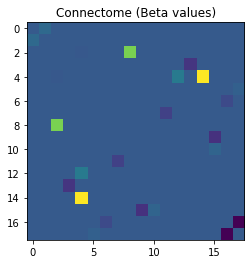

In [18]:
connectome = np.zeros((N, N))
for c in range(N):
    for r in range(N):
        roi1 = ROIs[c]
        roi2 = ROIs[r]
        conn_name = "%d-%d" % (min(roi1, roi2), max(roi1, roi2))
        entry = mlat5.loc[mlat5['connection'] == conn_name]

        if len(entry) == 1:
            beta=float(entry['Beta'])
            connectome[c,r] = beta
            
plt.imshow(connectome)
plt.title("Connectome (Beta values)")
plt.show()

Then, we need to create the corresponding list of x, y, z coordinates

In [19]:
xyz = []
sub.loc[:,['X', 'Y', 'Z']]
for roi in ROIs:
    entry = sub.loc[sub['ROI'] == roi]
    x = int(entry['X'])
    y = int(entry['Y'])
    z = int(entry['Z'])
    xyz.append((x,y,z))
coords = np.array(xyz)

And we select colors for each ROI using Power (2011)'s recommendations:

In [20]:
colors = []
sub.loc[:,['Color']]
for roi in ROIs:
    entry = sub.loc[sub['ROI'] == roi]
    #col = entry['Color']
    col = entry.iloc[0,5]
    colors.append(col.lower())
colors

['gray',
 'gray',
 'yellow',
 'yellow',
 'yellow',
 'yellow',
 'yellow',
 'yellow',
 'yellow',
 'yellow',
 'yellow',
 'yellow',
 'yellow',
 'yellow',
 'yellow',
 'yellow',
 'yellow',
 'yellow']

### Plotting the Connectomes

Then, with all the data structures available, we can finally visualize the data.

In [21]:
nip.view_connectome(adjacency_matrix=connectome,
                   node_coords=coords)

And now, the "glass brain" view

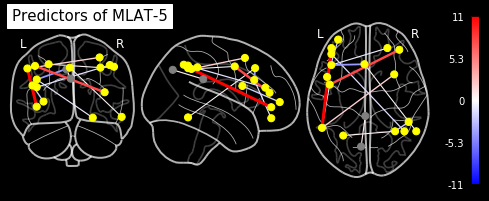

In [22]:
nip.plot_connectome(connectome, coords, colorbar=True,
                    title="Predictors of MLAT-5", black_bg=True, node_color=colors)
#plt.legend(labels=["Retrieval", "FPN"], loc="lower center")
plt.savefig("mlat5_predictors.png")
nip.show()

And, finally, the "ROI importance" view.

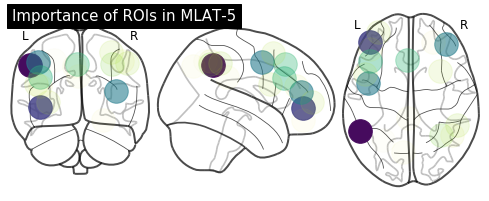

In [23]:
nip.plot_connectome_strength(connectome, coords,
                    title="Importance of ROIs in MLAT-5")
plt.savefig("mlat5_importance.png")
nip.show()

### Creating a generic function

Here we assemble all of the steps above into a single function.

In [24]:
### Create a Handy Function

def connectome_visualization(variable, name=None, blackbg=True):
    if name is None:
        name = variable
    # Load the data
    data = pd.read_csv("%s.csv" % (variable,))
    
    # Extract Regions
    ROIs = []

    for c in data['connection']:
        roi1, roi2 = c.split("-")

        if int(roi1) not in ROIs:
            ROIs.append(int(roi1))
        if int(roi2) not in ROIs:
            ROIs.append(int(roi2))
    ROIs.sort()

    # Extra ROI data
    sub = power2011[power2011['ROI'].isin( ROIs)]
    N = len(sub['ROI'])
    connectome = np.zeros((N, N))
    for c in range(N):
        for r in range(N):
            roi1 = ROIs[c]
            roi2 = ROIs[r]
            conn_name = "%d-%d" % (min(roi1, roi2), max(roi1, roi2))
            entry = data.loc[data['connection'] == conn_name]
            if len(entry) == 1:
                beta=float(entry['Beta'])
                connectome[c,r] = beta
            
    plt.imshow(connectome)
    plt.title("Connectome (Beta values)")
    plt.show()

    xyz = []
    sub.loc[:,['X', 'Y', 'Z']]
    for roi in ROIs:
        entry = sub.loc[sub['ROI'] == roi]
        x = int(entry['X'])
        y = int(entry['Y'])
        z = int(entry['Z'])
        xyz.append((x,y,z))
    coords = np.array(xyz)

    colors = []
    sub.loc[:,['Color']]
    for roi in ROIs:
        entry = sub.loc[sub['ROI'] == roi]
        #col = entry['Color']
        col = entry.iloc[0,5]
        colors.append(col.lower())

    nip.plot_connectome(connectome, coords, colorbar=True,
                    title=r"Predictors of %s" % (name,), 
                    black_bg=blackbg, node_color=colors)
    plt.savefig("%s.png" % (variable,))
    nip.show()

    nip.plot_connectome_strength(connectome, coords,
                                 title=r"Importance of ROIs in %s" % (name,))
    plt.savefig("%s_importance.png" % (variable,))
    nip.show()
    
    return connectome, coords, colors

## Symmetry Span

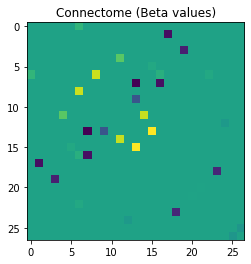

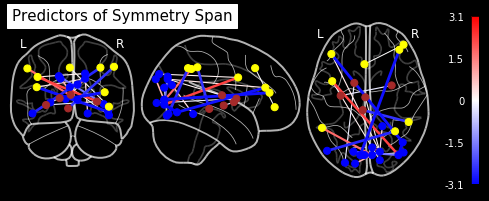

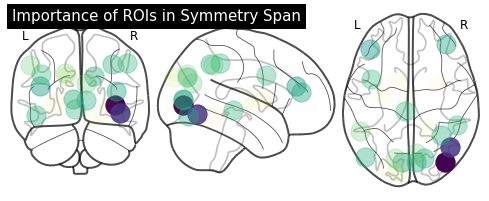

In [25]:
c, nc, cols = connectome_visualization("symmetryspan", name=r"Symmetry Span")
nip.view_connectome(adjacency_matrix=connectome,
                       node_coords=coords, colorbar_fontsize=10)

## Rate of Forgetting $\alpha$

We use the new function to plot a different variable, the Rate of Forgetting $\alpha$.

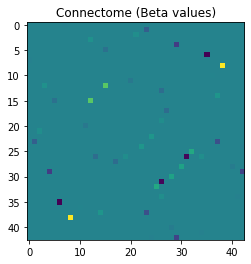

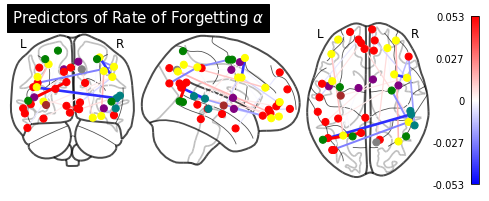

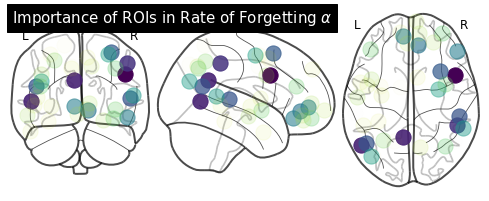

In [26]:
c, nc, cols = connectome_visualization("alpha3", name=r"Rate of Forgetting $\alpha$", blackbg=False)
nip.view_connectome(c, nc, colorbar_fontsize=8)

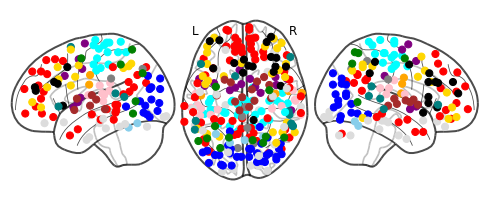

In [27]:
pc = np.zeros((264, 264))
pcol = [x.lower() for x in list(power2011['Color'])]
def colortranslate(x):
    if x.lower() == "yellow":
        return "gold"
    elif x.lower() == "pale blue":
        return "skyblue"
    elif x.lower() == "white":
        return "gainsboro"
    else:
        return x
    
pcol = [colortranslate(x) for x in pcol]
xyz = []
for roi in list(power2011['ROI']):
    entry = power2011.loc[power2011['ROI'] == roi]
    x = int(entry['X'])
    y = int(entry['Y'])
    z = int(entry['Z'])
    xyz.append((x,y,z))
pcoords = np.array(xyz)


nip.plot_connectome(pc, pcoords, node_color=pcol, display_mode='lzr')

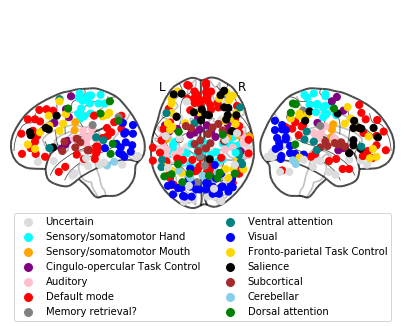

In [28]:
# Test
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
fig, axs = plt.subplots(1,1, figsize=(7,5))
nip.plot_connectome(pc, pcoords, node_color=pcol, display_mode='lzr', axes=axs)

allkols=list(power2011['Color'])
allnets=list(power2011['NetworkName'])

kols=[]
nets=[]
for i in range(len(allkols)):
    if not allkols[i] in kols:
        kols.append(allkols[i])
        nets.append(allnets[i])

handles = [Line2D([0], [0], marker='o', markerfacecolor=x, color="w", markersize=10) for x in [colortranslate(x) for x in kols]]

fig.legend(handles, nets, loc="lower center", ncol=2)

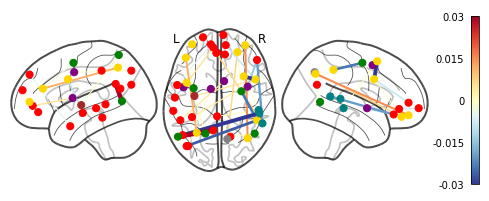

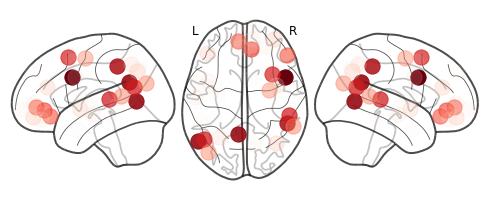

In [29]:
nip.plot_connectome(c, nc, [colortranslate(x) for x in cols], edge_cmap="RdYlBu_r", display_mode="lzr", colorbar=True, edge_vmax=0.03, edge_vmin=-0.03)
nip.plot_connectome_strength(c, nc, cmap="Reds", display_mode="lzr")